## RESERVOIR COMPUTING EXAMPLES

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll, rabinovich_fabrikant
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### 1. Rabinovich Fabrikant

The system is given by:

\begin{aligned}
\dot{x} &= y(z - 1 + x^2) + \gamma x \\
\dot{y} &= x(3z + 1 - x^2) + \gamma y \\
\dot{z} &= -2z(\alpha + xy)
\end{aligned}


In [2]:
dt = 0.005
train_time = 40.
test_time  = 300.
warm_time  = 6.

train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [3]:
x0 = [0.1, -0.1, 0.1]

n_timesteps = train_steps + test_steps + warm_steps
print("n_timesteps:", n_timesteps)

X = rabinovich_fabrikant(n_timesteps, h=dt, x0=x0, alpha=0.05, gamma=0.1)
# X = rabinovich_fabrikant(2500)

n_timesteps: 69200


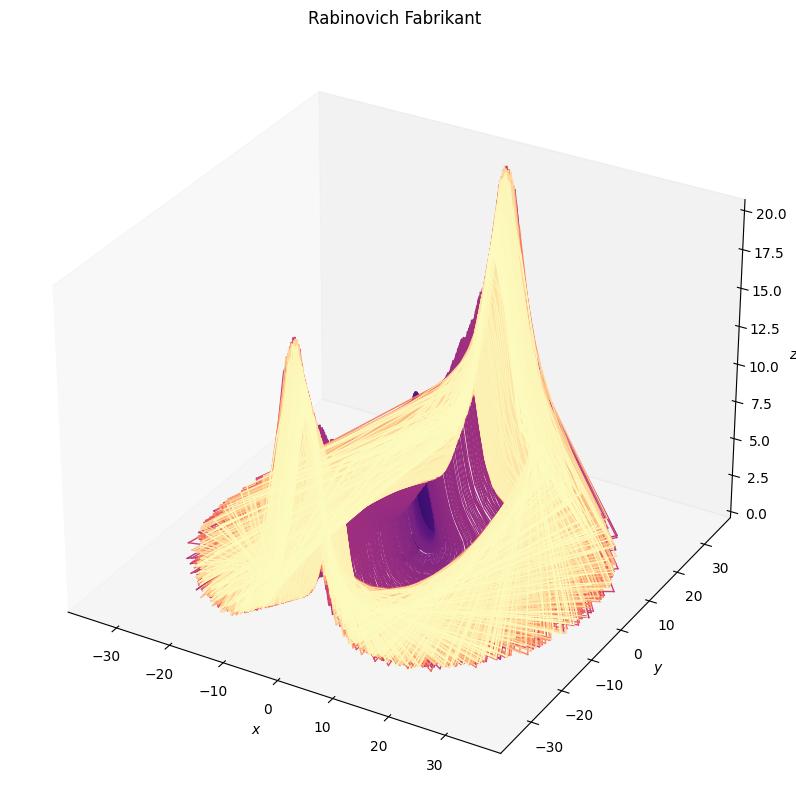

In [4]:
N = train_steps + warm_steps + test_steps

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Rabinovich Fabrikant")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.grid(False)

for i in range(N-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

plt.show()

In [5]:
nvar = NVAR(delay=1, order=3, strides=3)
readout = Ridge(3, ridge=0.01)

model = nvar >> readout

In [6]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

model = model.fit(Xi, dXi, warmup=warm_steps)

Running Model-0: 9199it [00:00, 31763.83it/s]?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Fitting node Ridge-0...


In [7]:
nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Running NVAR-0: 100%|██████████| 2/2 [00:00<00:00, 10143.42it/s]


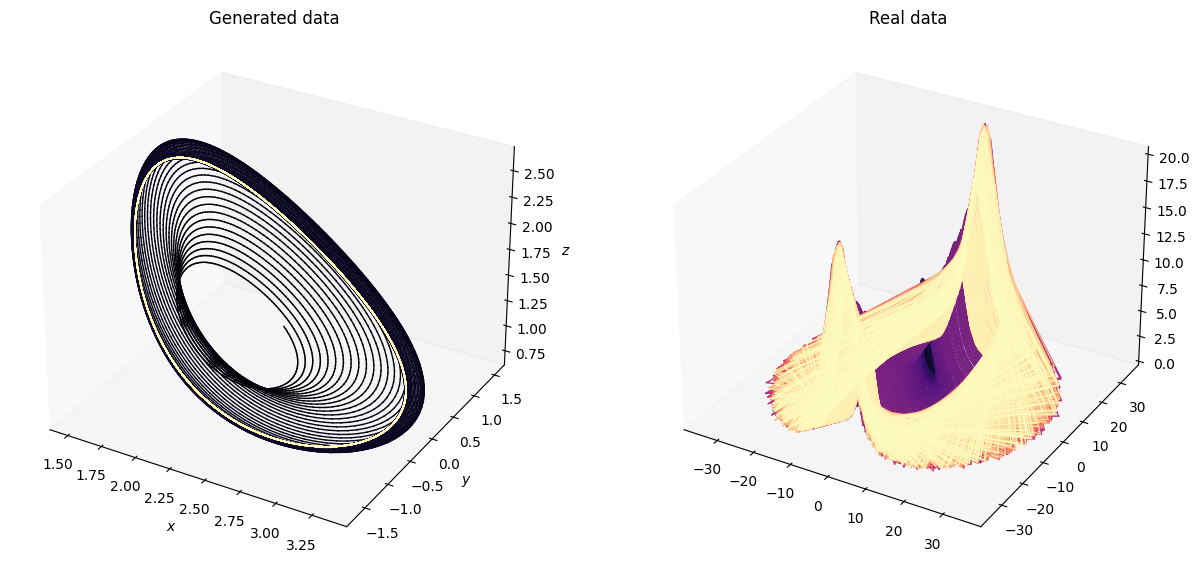

In [8]:
N = test_steps
Y = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(15, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.set_title("Generated data")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.grid(False)

for i in range(N-1):
    ax.plot(res[i:i+2, 0], res[i:i+2, 1], res[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real data")
ax2.grid(False)

for i in range(N-1):
    ax2.plot(Y[i:i+2, 0], Y[i:i+2, 1], Y[i:i+2, 2], color=plt.cm.magma(255*i//N), lw=1.0)